In [1]:
import pandas as pd
df = pd.read_csv(
    "http://www.thetransparencyproject.org/datasets/AnalyticDataset_Gray_LaPlante_PAB_2012.dat",
    delimiter="\\t",
    engine="python",
    na_values=" "
)

print('Number of Observations:',len(df))
print('Here are the features:',df.columns)
print('Here is the number of features',len(df.columns))

Number of Observations: 4132
Here are the features: Index(['UserID', 'RG_case', 'Missing_Daily_Transactions', 'First_Deposit_Date',
       'Registration_date', 'CountryName', 'LanguageName', 'Gender',
       'YearofBirth', 'age_at_registration', 'sum_stakes_fixedodds',
       'sum_bets_fixedodds', 'bettingdays_fixedodds', 'duration_fixedodds',
       'frequency_fixedodds', 'bets_per_day_fixedodds',
       'euros_per_bet_fixedodds', 'net_loss_fixedodds',
       'percent_lost_fixedodds', 'sum_stakes_liveaction',
       'sum_bets_liveaction', 'bettingdays_liveaction', 'duration_liveaction',
       'frequency_liveaction', 'bets_per_day_liveaction',
       'euros_per_bet_liveaction', 'net_loss_liveaction',
       'percent_lost_liveaction', 'sum_stakes_casino', 'sum_bets_casino',
       'bettingdays_casino', 'duration_casino', 'frequency_casino',
       'bets_per_day_casino', 'euros_per_bet_casino', 'net_loss_casino',
       'percent_lost_casino', 'net_loss_fixedodds_nonzero',
       'percen

In [2]:
df_types = df.dtypes
print('Unique types present in the dataframe:',pd.unique(df.dtypes))
print('Unique lables in RG_case column',df['RG_case'].unique())

Unique types present in the dataframe: [dtype('int64') dtype('O') dtype('float64')]
Unique lables in RG_case column [1 0]


In [3]:
n_unique = df.nunique(dropna=False)
print(n_unique[n_unique<=1].index)

Index([], dtype='object')


In [4]:
print('The number of Responsible Gambling',len(df[df['RG_case']==0]))
print('The number of Responsible Gambling',len(df[df['RG_case']==1]))

The number of Responsible Gambling 2066
The number of Responsible Gambling 2066


In [5]:
duplicated_cols = df.columns[df.T.duplicated()]
print(duplicated_cols)

Index([], dtype='object')


<BarContainer object of 97 artists>

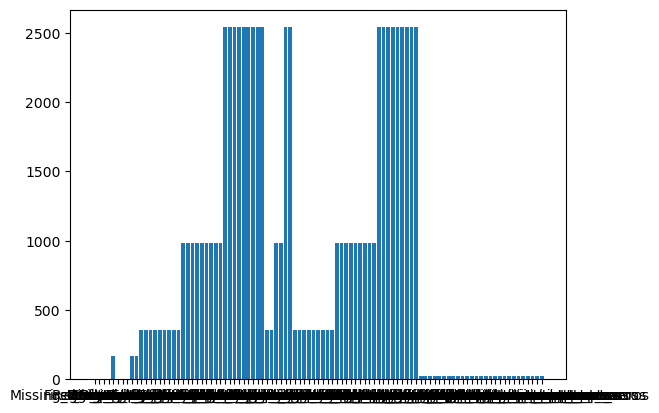

In [6]:
import matplotlib.pyplot as plt
missing_val = df.isna().sum()
plt.bar(df.columns, missing_val)
#plt.xticks(rotation=45)

In [7]:
print('The number of total features:',len(df.columns))
for clm in df.columns[1:]:
    if df[clm].isna().mean()>0.25:
        df.drop(clm,axis=1,inplace=True)

print('After droping features wih more that 1000 missing values more than 25% of observations', len(df.columns))

The number of total features: 97
After droping features wih more that 1000 missing values more than 25% of observations 77


In [8]:
from sklearn.model_selection import train_test_split
id_clm = 'UserID'
target_lb = 'RG_case'
data= df.drop(columns=target_lb)
lable = df[target_lb]

x_train,x_test,y_train,y_test = train_test_split(
    data,lable,test_size= 0.2,stratify=lable,random_state=42)

In [9]:
numerical_features = x_train.select_dtypes(include=['int64','float64']).columns
categorical_features = x_train.select_dtypes(include=['object','category']).columns 

numerical_features = numerical_features.drop(id_clm,errors='ignore')
categorical_features = categorical_features.drop(id_clm,errors='ignore')


In [10]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median", add_indicator=True)),
    ("scaler", StandardScaler())
])


In [11]:
from sklearn.preprocessing import OneHotEncoder

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Missing")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])


In [12]:
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


In [13]:
from sklearn.linear_model import LogisticRegression

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(
        class_weight="balanced",
        max_iter=1500,
        random_state=42
    ))
])

model.fit(x_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocessor', ...), ('classifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transforme

In [14]:
from sklearn.metrics import classification_report

y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.78      0.83      0.80       414
           1       0.82      0.76      0.79       413

    accuracy                           0.80       827
   macro avg       0.80      0.80      0.80       827
weighted avg       0.80      0.80      0.80       827

